In [1]:
!wget --no-check-certificate \
  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
  -O cats_and_dogs_filtered.zip

--2021-07-09 23:39:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.20.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   135MB/s    in 0.5s    

2021-07-09 23:39:51 (135 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
! unzip -q cats_and_dogs_filtered.zip

replace cats_and_dogs_filtered/vectorize.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [3]:
train_dir = "cats_and_dogs_filtered/train"
validation_dir = "cats_and_dogs_filtered/validation"

## Primero como siempre importamos los datos

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Ahora importamos la red y los pesos de la red VGG16

In [5]:
from tensorflow.keras.applications import VGG16

vgg_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [6]:
vgg_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

## Setear los parámetros del modelo base a no entrenable

In [7]:
vgg_base.trainable=False 

### Ahora hay que agregar las últimas capas de la red:

In [8]:
from tensorflow.keras import models
from tensorflow.keras import layers

model = models.Sequential()
model.add(vgg_base)
# agregar el final de la red
# una capa flatten
# una capa densa de 256 elementos
# una capa sigmoidea
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Entrenamos el modelo

In [9]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [10]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 28s 229ms/step - loss: 0.6105 - acc: 0.6705 - val_loss: 0.4659 - val_acc: 0.8130
Epoch 2/20
100/100 [==============================] - 21s 205ms/step - loss: 0.4908 - acc: 0.7860 - val_loss: 0.3877 - val_acc: 0.8320
Epoch 3/20
100/100 [==============================] - 22s 218ms/step - loss: 0.4262 - acc: 0.8200 - val_loss: 0.3688 - val_acc: 0.8180
Epoch 4/20
100/100 [==============================] - 22s 217ms/step - loss: 0.4021 - acc: 0.8255 - val_loss: 0.3216 - val_acc: 0.8570
Epoch 5/20
100/100 [==============================] - 21s 214ms/step - loss: 0.3687 - acc: 0.8465 - val_loss: 0.3031 - val_acc: 0.8620
Epoch 6/20
100/100 [==============================] - 22s 217ms/step - loss: 0.3758 - acc: 0.8325 - val_loss: 0.2987 - val_acc: 0.8630
Epoch 7/20
100/100 [==============================] - 22s 223ms/step - loss: 0.3548 - acc: 0.8400 - val_loss: 0.2947 - val_acc: 0.8710
Epoch 8/20
100/100 [==============================] - 2

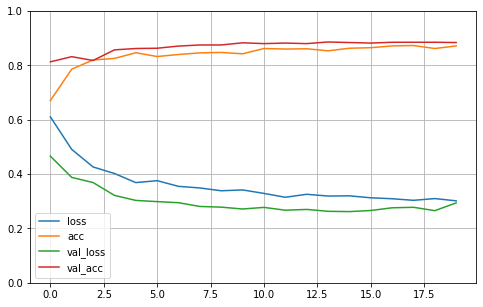

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [12]:
classes_dict={0:"cat",1:"dog"}

In [20]:
arena_generator = test_datagen.flow_from_directory(
        './Arena',
        target_size=(150, 150),
        shuffle=False,
        class_mode='binary')

predictions=(model.predict(arena_generator) >= 0.5)*1
[classes_dict[i[0]] for i in predictions]


Found 3 images belonging to 2 classes.


['dog', 'cat', 'dog']

In [21]:
popy_generator = test_datagen.flow_from_directory(
        './Popy',
        target_size=(150, 150),
        batch_size=4,
        shuffle=False,
        class_mode='binary')

predictions=(model.predict(popy_generator) >= 0.5)*1
[classes_dict[i[0]] for i in predictions]

Found 4 images belonging to 2 classes.


['cat', 'dog', 'cat', 'dog']

# TAREA: Hacer lo mismo con ResNet50:

In [24]:
from tensorflow.keras.applications import ResNet50
base_resnet = ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150, 150, 3),
    pooling=None,
    classes=2,
)

base_resnet.summary()
base_resnet.trainable=False 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [25]:
res_model = models.Sequential()
res_model.add(vgg_base)
res_model.add(layers.Flatten())
res_model.add(layers.Dense(256, activation='relu'))
res_model.add(layers.Dense(1, activation='sigmoid'))

res_model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=2e-5),
                metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
history = res_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=50)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
100/100 [==============================] - 24s 230ms/step - loss: 0.5999 - acc: 0.6850 - val_loss: 0.4802 - val_acc: 0.7840
Epoch 2/20
100/100 [==============================] - 23s 225ms/step - loss: 0.4827 - acc: 0.7860 - val_loss: 0.3814 - val_acc: 0.8420
Epoch 3/20
100/100 [==============================] - 21s 215ms/step - loss: 0.4357 - acc: 0.8115 - val_loss: 0.3478 - val_acc: 0.8460
Epoch 4/20
100/100 [==============================] - 20s 203ms/step - loss: 0.4096 - acc: 0.8230 - val_loss: 0.3272 - val_acc: 0.8520
Epoch 5/20
100/100 [==============================] - 22s 223ms/step - loss: 0.3697 - acc: 0.8360 - val_loss: 0.3042 - val_acc: 0.8550
Epoch 6/20
100/100 [==============================] - 22s 221ms/step - loss: 0.3735 - acc: 0.8370 - val_loss: 0.3017 - val_acc: 0.8670
Epoch 7/20
100/100 [==============================] - 22s 222ms/step - loss: 0.3633 - acc: 0.8405 - val_loss: 0.2986 - val_acc: 0.8710
Epoch 8/20
100/100 [==============================] - 2

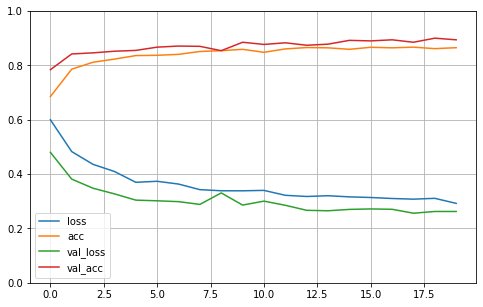

In [27]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [30]:
arena_generator = test_datagen.flow_from_directory(
        './Arena',
        target_size=(150, 150),
        shuffle=False,
        class_mode='binary')

predictions=(res_model.predict(arena_generator) >= 0.5)*1
[classes_dict[i[0]] for i in predictions]


Found 3 images belonging to 2 classes.


['dog', 'cat', 'dog']

In [31]:
popy_generator = test_datagen.flow_from_directory(
        './Popy',
        target_size=(150, 150),
        batch_size=4,
        shuffle=False,
        class_mode='binary')

predictions=(res_model.predict(popy_generator) >= 0.5)*1
[classes_dict[i[0]] for i in predictions]

Found 4 images belonging to 2 classes.


['cat', 'cat', 'cat', 'cat']